# Natural Language Processing with RNNs and Attention

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow_hub as hub
from pathlib import Path

IMAGES_PATH = Path() / "images" / "nlp"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Creating the Training Dataset

Let's download the Shakespeare data from Andrej Karpathy's char-rnn project

In [22]:
shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [23]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [24]:
# eshows all 39 distinct characters (after converting to lower case)
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

Next, we’ll use a tf.keras.layers.TextVectorization layer to encode this text. We set split="character" to get character-level encoding rather than the default word-level encoding, and we use standardize="lower" to convert the text to lowercase (which will simplify the task):

In [25]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

Each character is now mapped to an integer, starting at 2. The TextVectorization layer reserved the value 0 for padding tokens, and it reserved 1 for unknown characters. We won’t need either of these tokens for now, so let’s subtract 2 from the character IDs and compute the number of distinct characters and the total number of characters:

In [26]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

In [27]:
dataset_size, n_tokens

(1115394, 39)

Next, we can turn this very long sequence into a dataset of windows that we can then use to train a sequence-to-sequence RNN. The targets will be similar to the inputs, but shifted by one time step into the “future”. For example, one sample in the dataset may be a sequence of character IDs representing the text “to be or not to b” (without the final “e”), and the corresponding target—a sequence of character IDs representing the text “o be or not to be” (with the final “e”, but without the leading “t”). Let’s write a small utility function to convert a long sequence of character IDs into a dataset of input/target window pairs

In [28]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

* It takes a sequence as input (i.e., the encoded text), and creates a dataset containing all the windows of the desired length. 

* It increases the length by one, since we need the next character for the target. 

* Then, it shuffles the windows (optionally), batches them, splits them into input/output pairs, and activates prefetching.

The figure summarizes the dataset preparation steps: it shows windows of length 11, and a batch size of 3. The start index of each window is indicated next to it.

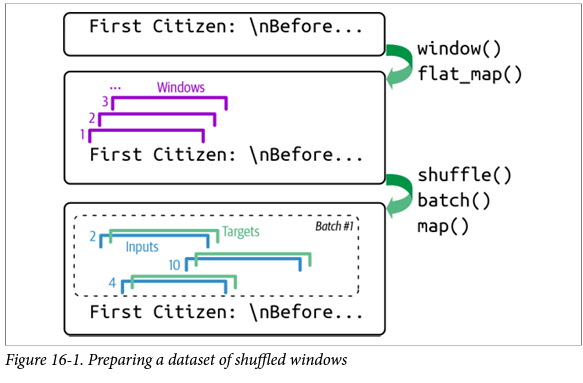

In [29]:
text_vec_layer(["To be"])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 4,  5,  2, 23,  3]], dtype=int64)>

In [30]:
text_vec_layer(["To be"])[0]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 4,  5,  2, 23,  3], dtype=int64)>

In [31]:
# extra code – a simple example using to_dataset()
# There's just one sample in this dataset: the input represents "to b" and the
# output represents "o be"
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]], dtype=int64)>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]], dtype=int64)>)]

Now we’re ready to create the training set, the validation set, and the test set. We will use roughly 90% of the text for training, 5% for validation, and 5% for testing:

In [32]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

We set the window length to 100, but you can try tuning it: it’s easier and faster to train RNNs on shorter input sequences, but the RNN will not be able to learn any pattern longer than length, so don’t make it too small.

## Building and Training the Char-RNN Model

Since our dataset is reasonably large, and modeling language is quite a difficult task, we need more than a simple RNN with a few recurrent neurons. 

In [33]:
n_tokens

39

In [35]:
tf.random.set_seed(42)  
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=1,
                    callbacks=[model_ckpt])

  31247/Unknown - 1377s 44ms/step - loss: 1.3964 - accuracy: 0.5722

INFO:tensorflow:Assets written to: my_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_shakespeare_model\assets


31247/31247 [==============================] - 1410s 45ms/step - loss: 1.3964 - accuracy: 0.5722 - val_loss: 1.5850 - val_accuracy: 0.5365


* We use an Embedding layer as the first layer, to encode the character IDs. The Embedding layer’s number of input dimensions is the number of distinct character IDs, and the number of output dimensions is a hyperparameter you can tune—we’ll set it to 16 for now. Whereas the inputs of the Embedding layer will be 2D tensors of shape [batch size, window length], the output of the Embedding layer will be a 3D tensor of shape [batch size, window length, embedding size].

* We use a Dense layer for the output layer: it must have 39 units (n_tokens) because there are 39 distinct characters in the text, and we want to output a probability for each possible character (at each time step). The 39 output probabilities should sum up to 1 at each time step, so we apply the softmax activation function to the outputs of the Dense layer.

* Lastly, we compile this model, using the "sparse_categorical_crossentropy" • loss and a Nadam optimizer, and we train the model for several epochs,3 using a ModelCheckpoint callback to save the best model (in terms of validation accuracy) as training progresses.

This model does not handle text preprocessing, so let’s wrap it in a final model containing the tf.keras.layers.TextVectorization layer as the first layer, plus a tf.keras.layers.Lambda layer to subtract 2 from the character IDs since we’re not using the padding and unknown tokens for now:

In [36]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

And now let’s use it to predict the next character in a sentence:

In [37]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 390ms/step


'e'

### Generating Fake Shakespearean Text

To generate new text using the char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it to the end of the text, then give the extended text to the model to guess the next letter, and so on. This is called greedy decoding. But in practice this often leads to the same words being repeated over and over again. Instead, we can sample the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s tf.random.categorical() function. This will generate more diverse and interesting text. 

The categorical() function samples random class indices, given the class log probabilities (logits). For example:

In [38]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)  # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]], dtype=int64)>

To have more control over the diversity of the generated text, we can divide the logits by a number called the temperature, which we can tweak as we wish. A temperature close to zero favors high-probability characters, while a high temperature gives all characters an equal probability. Lower temperatures are typically preferred when generating fairly rigid and precise text, such as mathematical equations, while higher temperatures are preferred when generating more diverse and creative text. The following next_char() custom helper function uses this approach to pick the next character to add to the input text:

In [39]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

Next, we can write another small helper function that will repeatedly call next_char() to get the next character and append it to the given text:

In [40]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [41]:
tf.random.set_seed(42)

In [42]:
print(extend_text("To be or not to be", temperature=0.01))

1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 25ms/step
To be or not to be the seat as i say,
a word to the soul, and the wo


In [43]:
print(extend_text("To be or not to be", temperature=1))

1/1 [==============================] - 0s 31ms/step
To be or not to be prove a brief?

provost:
i will have a she will n


In [44]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 39ms/step
To be or not to beg ,mt'&o3g:auy-$
ws-nse?pws3est--vberdqw!c-yjewznq


To generate more convincing text, a common technique is to sample only from the top k characters, or only from the smallest set of top characters whose total probability exceeds some threshold (this is called nucleus sampling). Alternatively, you could try using beam search, or using more GRU layers and more neurons per layer, training for longer, and adding some regularization if needed. Also note that the model is currently incapable of learning patterns longer than length, which is just 100 characters. You could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences. An alternative approach is to use a stateful RNN.

### Stateful RNN

We only used stateless RNNs above: at each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away as it is not needed anymore. What if we instructed the RNN to preserve this final state after processing a training batch and use it as the initial state for the next training batch? This way the model could learn long-term patterns despite only backpropagating through short sequences. This is called a stateful RNN. 

First, note that a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off. So the first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences (rather than the shuffled and overlapping sequences we used to train stateless RNNs). When creating the tf.data.Dataset, we must therefore use shift=length (instead of shift=1) when calling the window() method. Moreover, we must not call the shuffle() method.

不幸的是，為有stateful RNN 準備資料集比為stateless RNN 準備資料集要困難得多。 如果我們呼叫batch(32)，那麼32個連續的視窗將被放入同一個批次中，並且接下來的批次將不會繼續其中每個視窗的中斷處。 第一個批次將包含視窗1 到32，第二個批次將包含視窗33 到64，因此，如果您考慮每個批次的第一個視窗（即視窗1 和33），您可以看到它們不是連續的。 此問題最簡單的解決方案是僅使用批次大小 1。以下 to_dataset_for_stateful_rnn() 自訂實用程式函數使用此策略為有狀態 RNN 準備資料集：

In [45]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [46]:
# imple example using to_dataset_for_stateful_rnn()
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]])>)]

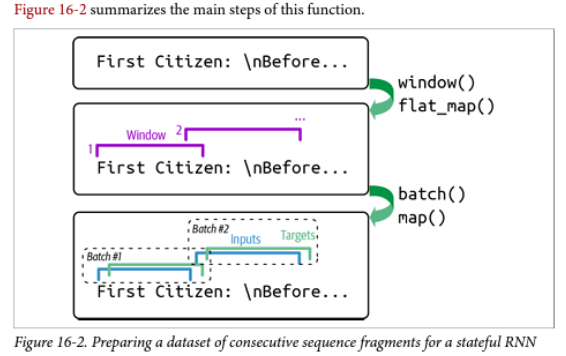

Batching is harder, but it is not impossible. For example, we could chop Shakespeare’s text into 32 texts of equal length, create one dataset of consecutive input sequences for each of them, and finally use tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows)) to create proper consecutive batches, where the nth input sequence in a batch starts off exactly where the nth input sequence ended in the previous batch.

If you'd like to have more than one window per batch, you can use the to_batched_dataset_for_stateful_rnn() function instead of to_dataset_for_stateful_rnn():

In [47]:
import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]])>)]

Now, let’s create the stateful RNN. We need to set the stateful argument to True when creating each recurrent layer, and because the stateful RNN needs to know the batch size (since it will preserve a state for each input sequence in the batch). Therefore we must set the batch_input_shape argument in the first layer. Note that we can leave the second dimension unspecified, since the input sequences could have any length:

In [48]:
tf.random.set_seed(42)  
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

At the end of each epoch, we need to reset the states before we go back to the beginning of the text. For this, we can use a small custom Keras callback:

In [49]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [50]:
# use a different directory to save the checkpoints
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

After this model is trained, it will only be possible to use it to make predictions for batches of the same size as were used during training. To avoid this restriction, create an identical stateless model, and copy the stateful model’s weights to this model.

## Sentiment Analysis

load the IMDb dataset using the TensorFlow Datasets library

In [4]:
import tensorflow_datasets as tfds

In [3]:
raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [4]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


 We will limit the vocabulary to 1,000 tokens, including the most frequent 998 words plus a padding token and a token for unknown words(這表示在向量化文本時，將使用最常見的998個單詞來構建詞彙表。), since it’s unlikely that very rare words will be important for this task, and limiting the vocabulary size will reduce the number of parameters the model needs to learn:

In [6]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, ragged=True)
#在這裡，我們只關心文本部分，因此使用了 lambda reviews, labels: reviews 來只保留文本，並忽略標籤。
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

The first layer is the TextVectorization layer we just prepared, followed by an Embedding layer that will convert word IDs into embeddings. The embedding matrix needs to have one row per token in the vocabulary (vocab_size) and one column per embedding dimension (this example uses 128 dimensions, but this is a hyperparameter you could tune). Next we use a GRU layer and a Dense layer with a single neuron and the sigmoid activation function, since this is a binary classification task: the model’s output will be the estimated probability that the review expresses a positive sentiment regarding the movie.

(by setting ragged=True, Keras’s recurrent layers have built-in support for ragged tensors, so there’s nothing else you need to do: just use this TextVectorization layer in your model. There’s no need to pass mask_zero=True or handle masks explicitly—it’s all implemented for you. That’s convenient!)

In [7]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 430s 606ms/step - loss: 0.5270 - accuracy: 0.7291 - val_loss: 0.3747 - val_accuracy: 0.8420
Epoch 2/2
704/704 [==============================] - 412s 586ms/step - loss: 0.3562 - accuracy: 0.8489 - val_loss: 0.3365 - val_accuracy: 0.8564


In [26]:
y_proba = model.predict(["This movie is bad"])

print(y_proba[0][0].round(2))

y_proba2 = model.predict(["This movie is good"])

print(y_proba2[0][0].round(2))

1/1 [==============================] - 0s 34ms/step
0.12
1/1 [==============================] - 0s 34ms/step
0.64


### Reusing Pretrained Embeddings and Language Models

 Instead of training word embeddings ourselves, we could just download and use pretrained embeddings, such as Google’s Word2vec embeddings, Stanford’s GloVe embeddings, or Facebook’s FastText embeddings.

This model is quite large—close to 1 GB in size—so it may take a while to download. By default, TensorFlow Hub modules are saved to a temporary directory, and they get downloaded again and again every time you run your program. To avoid that, you must set the TFHUB_CACHE_DIR environment variable to a directory of your choice: the modules will then be saved there, and only downloaded once. (Note that the last part of the TensorFlow Hub module URL specifies that we want version 4 of the model. This versioning ensures that if a new module version is released on TF Hub, it will not break our model. Conveniently, if you just enter this URL in a web browser, you will get the documentation for this module.)

In [ ]:

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=True, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)

## An Encoder–Decoder Network for Neural Machine Translation

Let’s begin with a simple NMT model that will translate English sentences to Spanish

簡而言之，架構如下：英文句子作為encoder的輸入，decoder輸出西班牙文翻譯。 請注意，西班牙語翻譯在訓練期間也用作decoder的輸入，但向後移動了一步。 換句話說，在訓練期間，解decoder將其在上一步中應輸出的單字作為輸入。This is called teacher forcing—a technique that significantly speeds up training and improves the model’s performance.

 For the very first word, the decoder is given the start-of-sequence (SOS) token, and the decoder is expected to end the sentence with an end-of-sequence (EOS) token.

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text(encoding="utf-8")

Each line contains an English sentence and the corresponding Spanish translation, separated by a tab. We’ll start by removing the Spanish characters “¡” and “¿”, which the TextVectorization layer doesn’t handle, then we will parse the sentence pairs and shuffle them. Finally, we will split them into two separate lists, one per language:

In [4]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [5]:
pairs[0:2]

[['How boring!', 'Qué aburrimiento!'], ['I love sports.', 'Adoro el deporte.']]

In [6]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


Next, let’s create two TextVectorization layers—one per language—and adapt them to the text:

In [7]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

* We limit the vocabulary size to 1,000, which is quite small. That’s because the • training set is not very large, and because using a small value will speed up training. State-of-the-art translation models typically use a much larger vocabulary (e.g., 30,000), a much larger training set (gigabytes), and a much larger model (hundreds or even thousands of megabytes). For example, check out the Opus-MT models by the University of Helsinki, or the M2M-100 model by Facebook. 

* Since all sentences in the dataset have a maximum of 50 words, we set • output_sequence_length to 50: this way the input sequences will automatically be padded with zeros until they are all 50 tokens long. If there was any sentence longer than 50 tokens in the training set, it would be cropped to 50 tokens. 

* For the Spanish text, we add “startofseq” and “endofseq” to each sentence when • adapting the TextVectorization layer: we will use these words as SOS and EOS tokens. You could use any other words, as long as they are not actual Spanish words.

Let’s inspect the first 10 tokens in both vocabularies. They start with the padding token, the unknown token, the SOS and EOS tokens (only in the Spanish vocabulary), then the actual words, sorted by decreasing frequency:

In [8]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [9]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

Next, let’s create the training set and the validation set (you could also create a test set if you needed it). We will use the first 100,000 sentence pairs for training, and the rest for validation. The decoder’s inputs are the Spanish sentences plus an SOS token prefix. The targets are the Spanish sentences plus an EOS suffix:

In [10]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

 We will use the functional API for that since the model is not sequential. It requires two text inputs—one for the encoder and one for the decoder—so let’s start with that:

In [11]:
tf.random.set_seed(42)  
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

Next, we need to encode these sentences using the TextVectorization layers we prepared earlier, followed by an Embedding layer for each language, with mask_zero=True to ensure masking is handled automatically. The embedding size is a hyperparameter you can tune, as always:

In [12]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

Now let’s create the encoder and pass it the embedded inputs:

In [13]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

To keep things simple, we just used a single LSTM layer, but you could stack several of them. We also set return_state=True to get a reference to the layer’s final state. Since we’re using an LSTM layer, there are actually two states: the short-term state and the long-term state. The layer returns these states separately, which is why we had to write *encoder_state to group both states in a list.16 

Now we can use this (double) state as the initial state of the decoder:

In [14]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

Next, we can pass the decoder’s outputs through a Dense layer with the softmax activation function to get the word probabilities for each step:

In [15]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

* Optimizing the Output 

Layer When the output vocabulary is large, outputting a probability for each and every possible word can be quite slow. If the target vocabulary contained, say, 50,000 Spanish words instead of 1,000, then the decoder would output 50,000-dimensional vectors, and computing the softmax function over such a large vector would be very computationally intensive. To avoid this, one solution is to look only at the logits output by the model for the correct word and for a random sample of incorrect words, then compute an approximation of the loss based only on these logits. This sampled softmax technique was introduced in 2015 by Sébastien Jean et al.17 In TensorFlow you can use the tf.nn.sampled_softmax_loss() function for this during training and use the normal softmax function at inference time (sampled softmax cannot be used at inference time because it requires knowing the target). Another thing you can do to speed up training—which is compatible with sampled softmax—is to tie the weights of the output layer to the transpose of the decoder’s embedding matrix (you will see how to tie weights in Chapter 17). This significantly reduces the number of model parameters, which speeds up training and may sometimes improve the model’s accuracy as well, especially if you don’t have a lot of training data. The embedding matrix is equivalent to one-hot encoding followed by a linear layer with no bias term and no activation function that maps the one-hot vectors to the embedding space. The output layer does the reverse. So, if the model can find an embedding matrix whose transpose is close to its inverse (such a matrix is called an orthogonal matrix), then there’s no need to learn a separate set of weights for the output layer

In [35]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 1937s 617ms/step - loss: 2.9063 - accuracy: 0.4296 - val_loss: 2.1509 - val_accuracy: 0.5275
Epoch 2/10
3125/3125 [==============================] - 1756s 562ms/step - loss: 1.8289 - accuracy: 0.5783 - val_loss: 1.6440 - val_accuracy: 0.6110
Epoch 3/10
3125/3125 [==============================] - 1714s 549ms/step - loss: 1.4235 - accuracy: 0.6519 - val_loss: 1.4195 - val_accuracy: 0.6554
Epoch 4/10
3125/3125 [==============================] - 1646s 527ms/step - loss: 1.1959 - accuracy: 0.6962 - val_loss: 1.3276 - val_accuracy: 0.6742
Epoch 5/10
3125/3125 [==============================] - 1801s 576ms/step - loss: 1.0350 - accuracy: 0.7290 - val_loss: 1.2908 - val_accuracy: 0.6814
Epoch 6/10
3125/3125 [==============================] - 1698s 543ms/step - loss: 0.9048 - accuracy: 0.7563 - val_loss: 1.2781 - val_accuracy: 0.6861
Epoch 7/10
3125/3125 [==============================] - 1673s 535ms/step - loss: 0.7920 - accuracy: 0.7818

After training, we can use the model to translate new English sentences to Spanish. But it’s not as simple as calling model.predict(), because the decoder expects as input the word that was predicted at the previous time step. One way to do this is to write a custom memory cell that keeps track of the previous output and feeds it to the encoder at the next time step. However, to keep things simple, we can just call the model multiple times, predicting one extra word at each round. Let’s write a little utility function for that:

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

The function simply keeps predicting one word at a time, gradually completing the translation, and it stops once it reaches the EOS token. 

In [ ]:
translate("I like soccer")

If you try playing with this model for a while, you will find that it’s not bilingual yet, and in particular it really struggles with longer sentences

One way is to increase the training set size and add more LSTM layers in both the encoder and the decoder. But this will only get you so far, so let’s look at more sophisticated techniques, starting with bidirectional recurrent layers.

## Bidirectional RNNs

At each time step, a regular recurrent layer only looks at past and present inputs before generating its output. In other words, it is causal, meaning it cannot look into the future. This type of RNN makes sense when forecasting time series, or in the decoder of a sequence-to-sequence (seq2seq) model. But for tasks like text classification, or in the encoder of a seq2seq model, it is often preferable to look ahead at the next words before encoding a given word.

One solution is to run two recurrent layers on the same inputs, one reading the words from left to right and the other reading them from right to left, then combine their outputs at each time step, typically by concatenating them. This is what a bidirectional recurrent layer does


To implement a bidirectional recurrent layer in Keras, just wrap a recurrent layer in a tf.keras.layers.Bidirectional layer. For example, the following Bidirectional layer could be used as the encoder:


In [2]:
tf.random.set_seed(42)  
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

There’s just one problem. This layer will now return four states instead of two: the final short-term and long-term states of the forward LSTM layer, and the final shortterm and long-term states of the backward LSTM layer. We cannot use this quadruple state directly as the initial state of the decoder’s LSTM layer, since it expects just two states (short-term and long-term). We cannot make the decoder bidirectional, since it must remain causal: otherwise it would cheat during training and it would not work. Instead, we can concatenate the two short-term states, and also concatenate the two long-term states:

In [16]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [20]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 2857s 912ms/step - loss: 2.9435 - accuracy: 0.4217 - val_loss: 2.2290 - val_accuracy: 0.5128
Epoch 2/10
3125/3125 [==============================] - 2967s 949ms/step - loss: 1.9162 - accuracy: 0.5620 - val_loss: 1.7213 - val_accuracy: 0.5961
Epoch 3/10
3125/3125 [==============================] - 2193s 702ms/step - loss: 1.4980 - accuracy: 0.6362 - val_loss: 1.4707 - val_accuracy: 0.6454
Epoch 4/10
3125/3125 [==============================] - 1676s 536ms/step - loss: 1.2561 - accuracy: 0.6833 - val_loss: 1.3594 - val_accuracy: 0.6659
Epoch 5/10
3125/3125 [==============================] - 1673s 535ms/step - loss: 1.0878 - accuracy: 0.7171 - val_loss: 1.3098 - val_accuracy: 0.6773
Epoch 6/10
3125/3125 [==============================] - 1653s 529ms/step - loss: 0.9542 - accuracy: 0.7455 - val_loss: 1.2876 - val_accuracy: 0.6840
Epoch 7/10
3125/3125 [==============================] - 1665s 533ms/step - loss: 0.8414 - accuracy: 0.7702

## Attention

Keras provides a tf.keras.layers.Attention layer for Luong attention, and an AdditiveAttention layer for Bahdanau attention. Let’s add Luong attention to our encoder–decoder model. Since we will need to pass all the encoder’s outputs to the Attention layer, we first need to set return_sequences=True when creating the encoder:

In [ ]:
tf.random.set_seed(42)  
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

Next, we need to create the attention layer and pass it the decoder’s states and the encoder’s outputs. However, to access the decoder’s states at each step we would need to write a custom memory cell. For simplicity, let’s use the decoder’s outputs instead of its states: in practice this works well too, and it’s much easier to code. Then we just pass the attention layer’s outputs directly to the output layer, as suggested in the Luong attention paper:

In [ ]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

The model now handles much longer sentences.

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))